In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import wandb
import torch.optim as opt
import torch.nn.functional as F
import random
import os

from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from Dataset import _VOCdataset
from utils import Random_processing
from torchinfo import summary

from Model.FCN import O_FCN8s
from Model.UNet import UNet


random.seed(123)
torch.manual_seed(123)

/home/kdb/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class config:
    # model_name = 'O_FCN8s'
    model_name = 'UNet_vgg16_bn_c10'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    max_epoch = 25
    batch_size = 16

In [3]:
mean = [0.4567, 0.4431, 0.4086]
std = [0.2680, 0.2649, 0.2806]

ds_train = _VOCdataset(mode='train', transform=Random_processing(mean, std))
ds_valid = _VOCdataset(mode='valid', transform=Random_processing(mean, std))

dl_train = DataLoader(ds_train, batch_size=config.batch_size, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=config.batch_size, shuffle=False)

In [4]:
wandb.login()
WANDB_CONFIG = {'_wandb_kernel' : 'neuracort'}
run = wandb.init(
    project='PASCAL VOC 2012 Semantic Segmentation - Loss ratio',
    config=WANDB_CONFIG
)
wandb.run.name = 'UNet with Vgg16 backbone'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: duriankim (durian). Use `wandb login --relogin` to force relogin


In [5]:
# model = O_FCN8s(n_class=22).to(config.device)
model = UNet().to(config.device)

/home/kdb/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kdb/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
class CombinedLoss(nn.Module):
    def __init__(self, weight=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.weight = weight
        self.smooth = smooth
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        
    def dice_loss(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets = F.one_hot(targets.long(), num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        
        intersection = (inputs * targets).sum((2, 3))
        dice = (2. * intersection + self.smooth) / (inputs.sum((2, 3)) + targets.sum((2, 3)) + self.smooth)
        
        return 1 - dice.mean()
    
    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy_loss(inputs, targets.squeeze().long())
        dl_loss = self.dice_loss(inputs, targets.squeeze().long())
        return self.weight * ce_loss + (1 - self.weight) * dl_loss


loss_fn = CombinedLoss(weight=1.0)
optimizer = opt.Adam(model.parameters(), lr=1e-3)

In [7]:
class engine():
    def model_train(model, data, optimizer, loss_func):
        imgs, lbls = data['image'], data['label']
        model.train()

        imgs = imgs.to(config.device)
        lbls = lbls.to(config.device)

        preds = model(imgs)
        loss = loss_func(preds, lbls)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        return loss.item()
    
    @torch.no_grad()
    def model_valid(model, data, loss_func):
        imgs, lbls = data['image'], data['label']
        model.eval()

        imgs = imgs.to(config.device)
        lbls = lbls.to(config.device)

        preds = model(imgs)
        loss= loss_func(preds, lbls)

        return loss.item()

In [8]:
log_path = f'Model/{config.model_name}/log'
best_model_path = log_path + '/best_model'

# Check log & best model path
if os.path.exists(best_model_path):
    pass
else:
    os.makedirs(best_model_path)

# Set test image
test_sample = next(iter(dl_valid))
test_img, test_lbl = test_sample['image'], test_sample['label']

# Save the view image and mask image
view_img = test_img[0].squeeze().permute(1,2,0).detach().cpu().numpy()
view_lbl = test_lbl[0].squeeze().detach().cpu().numpy()


# Reverse the normalization
view_img = (view_img*np.array(std) + np.array(mean))*255.0
view_img = view_img.astype(np.int16)

test_img = test_img.to(config.device)

/home/kdb/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
def run():
    best_val_loss = 1e10
    
    for epoch in range(config.max_epoch):
        print('-----------------------------')
        print(f'    Epoch : {epoch}')
        print('-----------------------------')


        for _, data in tqdm(enumerate(dl_train), total=len(dl_train)):
            train_loss= engine.model_train(model, data, optimizer, loss_fn)

        for _, data in tqdm(enumerate(dl_valid), total=len(dl_valid)):
            valid_loss= engine.model_valid(model, data, loss_fn)

        torch.save(model.state_dict(), os.path.join(log_path, f'epoch_{epoch}.pth'))

        if valid_loss < best_val_loss:
            torch.save(model.state_dict(), os.path.join(best_model_path, 'best_model.pth'))
            best_val_loss = valid_loss

        with torch.no_grad():
            model.eval()
            
            view_preds = model(test_img)
            view_preds = torch.argmax(view_preds, dim=1)
            view_pred = view_preds[0].detach().cpu().numpy()
            view_pred = view_pred.astype(np.int16)

        wandb.log(
            {
                'epoch' : epoch,
                'train_loss' : train_loss,
                'valid_loss' : valid_loss,
                'Color Image' : [wandb.Image(view_img, caption='Color image', mode="RGB")],
                'Ground Truth' : [wandb.Image(view_lbl, caption='Ground truth', mode="L")],
                'Model prediction' : [wandb.Image(view_pred, caption='Model Prediction', mode="L")]
            }   
        )
        print()

run()

-----------------------------
    Epoch : 0
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.20it/s]



-----------------------------
    Epoch : 1
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.21it/s]



-----------------------------
    Epoch : 2
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.22it/s]



-----------------------------
    Epoch : 3
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.21it/s]



-----------------------------
    Epoch : 4
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.20it/s]



-----------------------------
    Epoch : 5
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.16it/s]



-----------------------------
    Epoch : 6
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.17it/s]



-----------------------------
    Epoch : 7
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.14it/s]



-----------------------------
    Epoch : 8
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.15it/s]



-----------------------------
    Epoch : 9
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.17it/s]



-----------------------------
    Epoch : 10
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.19it/s]



-----------------------------
    Epoch : 11
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.17it/s]



-----------------------------
    Epoch : 12
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.15it/s]



-----------------------------
    Epoch : 13
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.17it/s]



-----------------------------
    Epoch : 14
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.17it/s]



-----------------------------
    Epoch : 15
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.18it/s]



-----------------------------
    Epoch : 16
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.15it/s]



-----------------------------
    Epoch : 17
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.18it/s]



-----------------------------
    Epoch : 18
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.14it/s]



-----------------------------
    Epoch : 19
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.15it/s]



-----------------------------
    Epoch : 20
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.15it/s]



-----------------------------
    Epoch : 21
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.13it/s]



-----------------------------
    Epoch : 22
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.17it/s]



-----------------------------
    Epoch : 23
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.14it/s]



-----------------------------
    Epoch : 24
-----------------------------


100%|██████████| 91/91 [00:11<00:00,  8.17it/s]


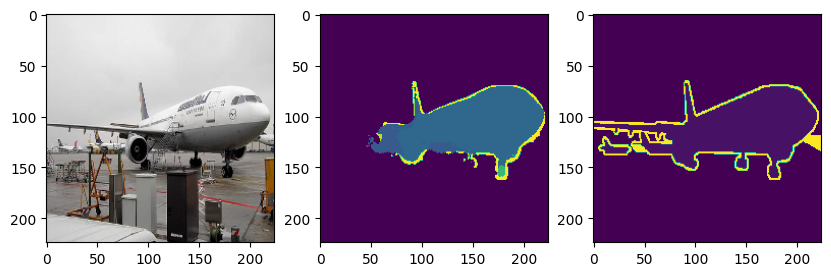

In [10]:
log_path = f'Model/{config.model_name}/log'
best_model_path = log_path + '/best_model'

# model = O_FCN8s(n_class=22).to(config.device)
model = UNet().to(config.device)



best_model_weight = torch.load(os.path.join(best_model_path, 'best_model.pth'))
model.load_state_dict(best_model_weight)

test_sample = next(iter(dl_valid))
test_img, test_lbl = test_sample['image'], test_sample['label']

# Save the view image and mask image
view_img = test_img[0].squeeze().permute(1,2,0).detach().cpu().numpy()
view_lbl = test_lbl[0].squeeze().detach().cpu().numpy()


# Reverse the normalization
view_img = (view_img*np.array(std) + np.array(mean))*255.0
view_img = view_img.astype(np.int16)

test_img = test_img.to(config.device)


with torch.no_grad():
    model.eval()
    
    view_preds = model(test_img)
    view_preds = torch.argmax(view_preds, dim=1)
    view_pred = view_preds[0].detach().cpu().numpy()
    view_pred = view_pred.astype(np.int16)


plt.figure(figsize=(10,12))
plt.subplot(1,3,1)
plt.imshow(view_img)
plt.subplot(1,3,2)
plt.imshow(view_pred)
plt.subplot(1,3,3)
plt.imshow(view_lbl)

In [11]:
np.unique(view_pred)

array([ 0,  6,  7, 14, 19, 21], dtype=int16)

In [12]:
np.unique(view_lbl)

array([ 0,  1, 21], dtype=uint8)

In [13]:
import torch

log_path = f'Model/{config.model_name}/log'
best_model_path = log_path + '/best_model'

# model = O_FCN8s(n_class=22).to(config.device)
model = UNet().to(config.device)

best_model_weight = torch.load(os.path.join(best_model_path, 'best_model.pth'))
model.load_state_dict(best_model_weight)

def fast_hist(pred, label, n_class):
    mask = (label >= 0) & (label < n_class)
    hist = torch.bincount(
        n_class * label[mask].view(-1).long() + pred[mask].view(-1),
        minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

def compute_IoU_per_class(hist):
    intersection = torch.diag(hist)
    union = hist.sum(1) + hist.sum(0) - intersection
    IoU = intersection / union
    return IoU

model.eval()
n_class = 22
total_hist = torch.zeros((n_class, n_class), device=config.device)  

with torch.no_grad():
    for data in dl_valid:
        img, lbl = data['image'], data['label']
        img = img.to(config.device)
        lbl = lbl.to(config.device).squeeze(1)  
        preds = model(img)
        preds = torch.argmax(preds, dim=1)  
        
        for pred, label in zip(preds, lbl):
            total_hist += fast_hist(pred, label, n_class).to(config.device)  
IoUs = compute_IoU_per_class(total_hist)

for i, IoU in enumerate(IoUs):
    print(f"Class {i} IoU: {IoU.item(): .4f}")


Class 0 IoU:  0.8123
Class 1 IoU:  0.0001
Class 2 IoU:  0.0000
Class 3 IoU:  0.0304
Class 4 IoU:  0.0000
Class 5 IoU:  0.0000
Class 6 IoU:  0.2769
Class 7 IoU:  0.1942
Class 8 IoU:  0.2168
Class 9 IoU:  0.0000
Class 10 IoU:  0.0036
Class 11 IoU:  0.0007
Class 12 IoU:  0.1582
Class 13 IoU:  0.0934
Class 14 IoU:  0.1686
Class 15 IoU:  0.4472
Class 16 IoU:  0.0035
Class 17 IoU:  0.0030
Class 18 IoU:  0.0000
Class 19 IoU:  0.0514
Class 20 IoU:  0.0000
Class 21 IoU:  0.1444
